In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

In [39]:
# Load the dataset
data = pd.read_csv('diabetes.csv')

# Check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# Separate features and target
X = data.drop('Outcome', axis=1)  # Features
y = data['Outcome']  # Target

In [29]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Function to plot k-distance graph for epsilon estimation
def plot_k_distance(X, k=4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title('K-Distance Graph')
    plt.tight_layout()


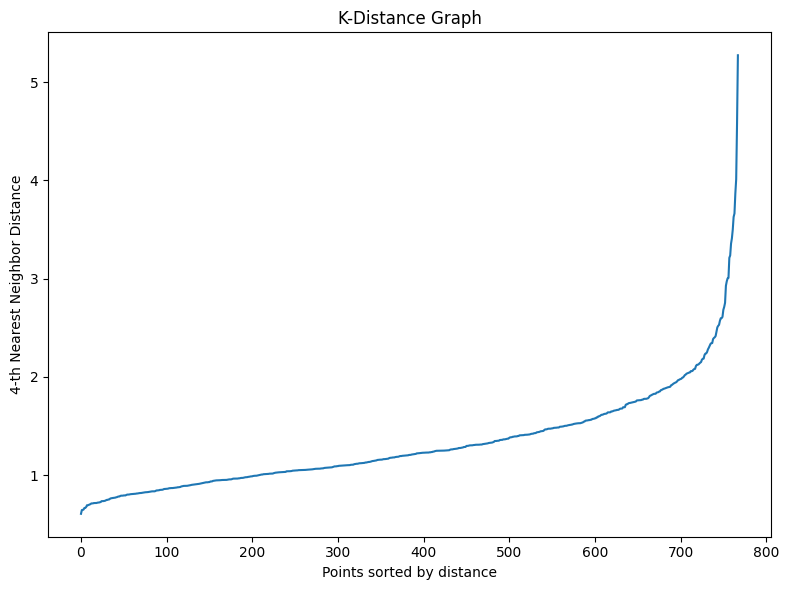

In [30]:
# Plot k-distance graph to estimate epsilon
plot_k_distance(X_scaled, k=4)

In [31]:
# Parameter tuning for DBSCAN
eps_range = np.arange(0.5, 3.0, 0.5)  # Test epsilon from 0.5 to 3.0
min_pts_range = range(3, 11)  # Test MinPts from 3 to 10
best_eps = 0
best_min_pts = 0
best_silhouette = -1
best_labels = None
results = []

for eps in eps_range:
    for min_pts in min_pts_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_pts)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Calculate silhouette score if more than one cluster
        if n_clusters > 1:
            silhouette = silhouette_score(X_scaled, labels)
        else:
            silhouette = -1  # Invalid clustering
            
        results.append({
            'eps': eps,
            'min_pts': min_pts,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })
        
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_eps = eps
            best_min_pts = min_pts
            best_labels = labels

# Print tuning results
results_df = pd.DataFrame(results)
print("\nParameter Tuning Results:\n", results_df)


Parameter Tuning Results:
     eps  min_pts  n_clusters  n_noise  silhouette
0   0.5        3           3      759   -0.342898
1   0.5        4           0      768   -1.000000
2   0.5        5           0      768   -1.000000
3   0.5        6           0      768   -1.000000
4   0.5        7           0      768   -1.000000
5   0.5        8           0      768   -1.000000
6   0.5        9           0      768   -1.000000
7   0.5       10           0      768   -1.000000
8   1.0        3          13      417   -0.262587
9   1.0        4           8      467   -0.269784
10  1.0        5           4      511   -0.168370
11  1.0        6           3      546   -0.149908
12  1.0        7           3      565   -0.190466
13  1.0        8           2      590   -0.121131
14  1.0        9           2      594   -0.122613
15  1.0       10           2      617   -0.107504
16  1.5        3           5      117    0.144559
17  1.5        4           3      131    0.226316
18  1.5        5      

In [32]:
# Best DBSCAN model
print(f"\nBest Parameters: eps={best_eps}, MinPts={best_min_pts}")
print(f"Silhouette Score: {best_silhouette}")
print(f"Number of Clusters: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")
print(f"Number of Noise Points: {list(best_labels).count(-1)}")


Best Parameters: eps=2.5, MinPts=3
Silhouette Score: 0.37794020959917374
Number of Clusters: 2
Number of Noise Points: 16


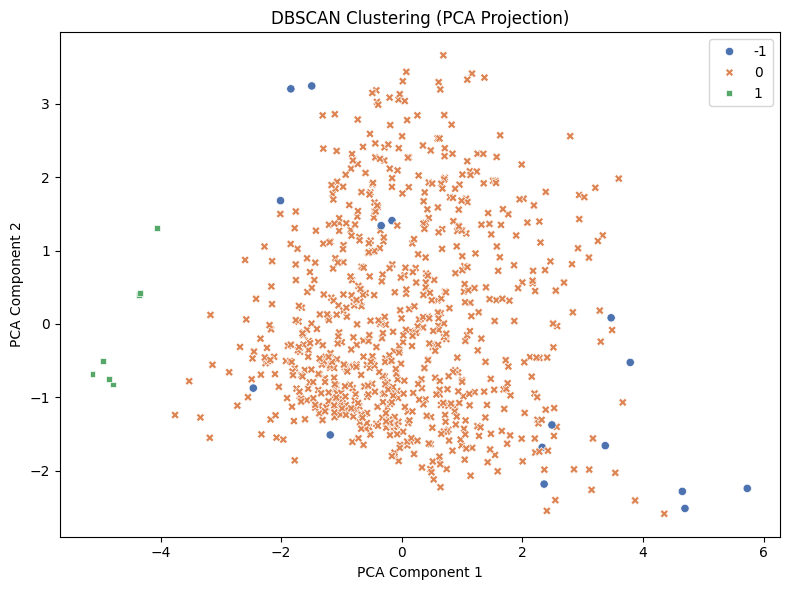

In [33]:
# Visualize clusters (using first two principal components for 2D plot)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=best_labels, palette='deep', style=best_labels)
plt.title('DBSCAN Clustering (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()


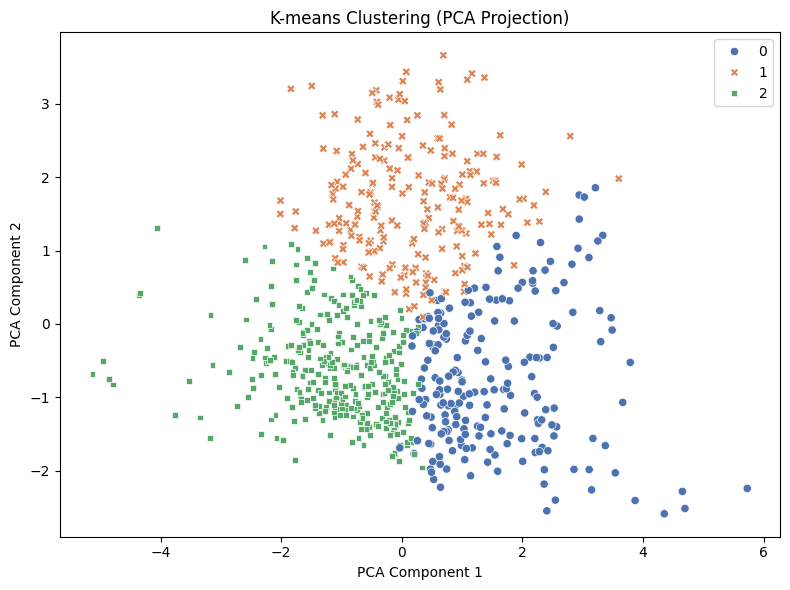

In [40]:
# Save comparison plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='deep', style=kmeans_labels)
plt.title('K-means Clustering (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()